In [2]:
# # install and upgrade the 3rd party packages
# !pip install plotly-express
# !pip install --upgrade numpy
# !pip install --upgrade scipy

In [6]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

import pickle # to save binary objects like the model and other data processors


from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix, accuracy_score

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

connect = f'sqlite:///FPA_FOD_20170508.sqlite'
engine = create_engine(connect)

In [11]:
engine = create_engine(connect)
f_df  = pd.read_sql_query(f"""
            SELECT
                *, 
                datetime(DISCOVERY_DATE) as DIS_DATETIME,
                datetime(CONT_DATE) as CON_DATETIME
            FROM 
                Fires 
            """ , engine)
f_df['DISC_YM'] = f_df['DIS_DATETIME'].str.extract(r'(\d{4}-\d{2})')
# df = pd.read_sql_query('SELECT COUNT(*) FROM Fires LIMIT 5;', engine)

# show shape
print(f_df.shape)

# change the DIS_DATETIME dtype to datetime
f_df['DIS_DATETIME'] = pd.to_datetime(f_df['DIS_DATETIME'])




# show top data
f_df.head()

(1880465, 42)


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,DIS_DATETIME,CON_DATETIME,DISC_YM
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,"2,453,403.50",33,1300,9.00,Miscellaneous,"2,453,403.50",33.00,1730,0.10,A,40.04,-121.01,5.00,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@|\x01\x00\x00\x00\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@\xfe',2005-02-02,2005-02-02 00:00:00,2005-02
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,"2,453,137.50",133,0845,1.00,Lightning,"2,453,137.50",133.00,1530,0.25,A,38.93,-120.40,5.00,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\xc0\x90\xc6U]nwC@T\xb6\xeej\xe2\x19^\xc0\x90\xc6U]nwC@|\x01\x00\x00\x00T\xb6\xeej\xe2\x19^\xc0\x90\xc6U]nwC@\xfe',2004-05-12,2004-05-12 00:00:00,2004-05
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,"2,453,156.50",152,1921,5.00,Debris Burning,"2,453,156.50",152.00,2024,0.10,A,38.98,-120.74,13.00,STATE OR PRIVATE,CA,17,017,El Dorado,"b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\xc0P\xbbf,\xf9}C@\xd0\xa5\xa0W\x13/^\xc0P\xbbf,\xf9}C@|\x01\x00\x00\x00\xd0\xa5\xa0W\x13/^\xc0P\xbbf,\xf9}C@\xfe'",2004-05-31,2004-05-31 00:00:00,2004-05
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,"2,453,184.50",180,1600,1.00,Lightning,"2,453,189.50",185.00,1400,0.10,A,38.56,-119.91,5.00,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]\xc0\xe8T\x00\xc6\x92GC@\x94\xac\xa3\rt\xfa]\xc0\xe8T\x00\xc6\x92GC@|\x01\x00\x00\x00\x94\xac\xa3\rt\xfa]\xc0\xe8T\x00\xc6\x92GC@\xfe',2004-06-28,2004-07-03 00:00:00,2004-06
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,"2,453,184.50",180,1600,1.00,Lightning,"2,453,189.50",185.00,1200,0.10,A,38.56,-119.93,5.00,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\xc0\xe8T\x00\xc6\x92GC@@\xe3\xaa.\xb7\xfb]\xc0\xe8T\x00\xc6\x92GC@|\x01\x00\x00\x00@\xe3\xaa.\xb7\xfb]\xc0\xe8T\x00\xc6\x92GC@\xfe',2004-06-28,2004-07-03 00:00:00,2004-06


In [ ]:
# check for duplicate
f_df.duplicated().sum()

0

In [11]:
# plot figure
fig2 = go.Figure()
# plot
fig2.add_trace(
                go.Bar(x=county_counts['FIPS_NAME'], y=county_counts['count'])
                )
# Set labels and title
fig2.update_layout({
                    "title": "Fire-prone Counties",
                    "yaxis": {"title":"Number of Wildfires"},
                    "xaxis": {"title":"County Names"}
                   })

# Add range slider and buttons
fig2.update_layout(
                    xaxis=dict(rangeslider=dict(visible=True))
                   )

fig2.show()                                                    

## Predict the cause of a wildfire?

In [68]:
f_df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'Shape', 'DISC_DATE', 'DISC_DATE_YM'], dtype='object')

Few thing to consider before the model development

**Potential Features:**
* `FIRE_SIZE`: Estimate of acres within the final perimeter of the fire.
* `FIRE_SIZE_CLASS`: Code for fire size based on the number of acres within the final fire perimeter expenditures. It is encoded as follows - 
        - A = greater than 0 but less than or equal to 0.25 acres
        - B = 0.26-9.9 acres
        - C = 10.0-99.9 acres
        - D = 100-299 acres
        - E = 300 to 999 acres
        - F = 1000 to 4999 acres
        - G = 5000+ acres   
        
**Note**: The two columns are the same, hence only the most helpful to predict cause of wire would be selected

* `LATITUDE`: Latitude (NAD83) for point location of the fire (decimal degrees).
* `LONGITUDE`: Longitude (NAD83) for point location of the fire (decimal degrees).

**Note**: These two columns are enough to explain all location properties. i.e no need for county name, state, and other location ids
* `DIS_DATETIME`: Date on which the fire was discovered or confirmed to exist

**Target variale:**
* `STAT_CAUSE_DESCR`: Description of the (statistical) cause of the fire.
* `STAT_CAUSE_CODE`: Code for the (statistical) cause of the fire

**Note**: Since the cause of fire has already been encoded as in the STAT_CAUSE_CODE column, this would be used as the target variable. **Edit:** XGBClassifier rejects labels ot starting from 0.

In [12]:
# Find how the fire causes were encoded
fire_cause_code = pd.read_sql_query("SELECT DISTINCT(STAT_CAUSE_DESCR), STAT_CAUSE_CODE FROM Fires;", engine)

fire_cause_code

,STAT_CAUSE_DESCR,STAT_CAUSE_CODE
0,Miscellaneous,9.00
1,Lightning,1.00
2,Debris Burning,5.00
3,Campfire,4.00
4,Equipment Use,2.00
5,Arson,7.00
6,Children,8.00
7,Railroad,6.00
8,Smoking,3.00
9,Powerline,11.00


In [14]:
target_var = 'STAT_CAUSE_DESCR'
# select size, location ad date columns
gen_model_df = f_df[['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'DIS_DATETIME', 'STAT_CAUSE_DESCR']].copy()

gen_model_df.head()

,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,DIS_DATETIME,STAT_CAUSE_DESCR
0,0.10,A,40.04,-121.01,2005-02-02,Miscellaneous
1,0.25,A,38.93,-120.40,2004-05-12,Lightning
2,0.10,A,38.98,-120.74,2004-05-31,Debris Burning
3,0.10,A,38.56,-119.91,2004-06-28,Lightning
4,0.10,A,38.56,-119.93,2004-06-28,Lightning


In [133]:
f_df["FIRE_SIZE_CLASS"].value_counts().sort_index()

A    1880465
Name: FIRE_SIZE_CLASS, dtype: int64

In [150]:
A = 0.0-0.25
B = 0.26-9.9
C = 10-99.99
D = 100-299.99
E = 300-999.99
F = 1000-4999.99
G = 5000-1000000

x = 999
if x > 5000.00:
        size = 'G'
elif x >= 1000.00:
    size = "F"
elif x >= 300.00:
    size = "E"
elif x >= 100.00:
    size = "D"
elif x >= 10.00:
    size = "C"
elif x >= 0.26:
    size = "B"
elif x < 0.25:
    size = "A"

print(size)

E


In [132]:
filter_ = f_df["FIRE_SIZE_CLASS"] == 'B'
f_df["FIRE_SIZE"][filter_].value_counts().sort_index()

Series([], Name: FIRE_SIZE, dtype: int64)

### Test Set

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, test_index in split.split(gen_model_df, gen_model_df[target_var]):
    model_df = gen_model_df.loc[train_index]
    test_set = gen_model_df.loc[test_index]
    

print("Full set:\n", gen_model_df[target_var].value_counts().sort_index() / len(gen_model_df))
print("\nmodel_df:\n", model_df[target_var].value_counts().sort_index() / len(model_df))
print("\n test_set:\n", test_set[target_var].value_counts().sort_index() / len(test_set))

Full set:
 Arson                               0.15
Campfire                            0.04
Children                            0.03
Debris Burning                      0.23
Equipment Use                       0.08
Fireworks                           0.01
Lightning                           0.15
Miscellaneous                       0.17
Missing/Undefined                   0.09
Powerline                           0.01
Railroad                            0.02
Smoking                             0.03
Structure                           0.00
Name: STAT_CAUSE_DESCR, dtype: float64

model_df:
 Arson                               0.15
Campfire                            0.04
Children                            0.03
Debris Burning                      0.23
Equipment Use                       0.08
Fireworks                           0.01
Lightning                           0.15
Miscellaneous                       0.17
Missing/Undefined                   0.09
Powerline                           

In [16]:
print('Dimensions of model training set:',model_df.shape)
print('Dimensions of Test set:',test_set.shape)

Dimensions of model training set: (1504372, 6)
Dimensions of Test set: (376093, 6)


### Feature Extraction and Engineering


* Extract `Year`, `Month`, `Day`, `Week_of_Year`, `Season` (Winter, Autumn etc) from the DIS_DATETIME column
* Create new columns with the extracted informations from above
* Create a new column `Distance` using the long and lat

In [17]:
model_df['Year'] = model_df['DIS_DATETIME'].dt.year
model_df['Month'] = model_df['DIS_DATETIME'].dt.month
model_df['Day'] = model_df['DIS_DATETIME'].dt.day
model_df['Week_of_Year'] = model_df['DIS_DATETIME'].dt.isocalendar().week

model_df['Season'] = np.select(condlist= [model_df['Month'].isin([12, 1, 2]),
                                          model_df['Month'].isin([3, 4, 5]),
                                          model_df['Month'].isin([6, 7, 8]),
                                          model_df['Month'].isin([9, 10, 11])],
                               choicelist= ['winter',
                                            'spring',
                                            'summer',
                                            'autumn'],
                              default= np.nan
                              )


model_df.drop(columns="DIS_DATETIME", inplace=True)
model_df.head()

,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,Year,Month,Day,Week_of_Year,Season
1250819,1.00,B,31.65,-82.50,Arson,2001,11,14,46,autumn
560820,0.13,A,35.72,-105.23,Smoking,2003,7,3,27,summer
808136,3.00,B,34.40,-88.22,Arson,2003,1,19,3,winter
1692569,20.00,C,32.20,-99.18,Miscellaneous,2013,8,4,31,summer
1550957,7.00,B,30.73,-97.18,Equipment Use,2011,2,20,7,winter


The four seasons and in the month of the year which they occur:

- _Winter_ – December, January and February.
- _Spring_ – March, April and May.
- _Summer_ – June, July and August.
- _Autumn_ – September, October and November. In autumn the weather turns colder and often rains.

**reference**: https://www.lutley.dudley.sch.uk/useruploads//Year%201%20Science%20seasons.pdf

How latitude affect climate:
- Places with latitudes closer to the Equator (lat-0) have hotter climates. Places with latitudes closer to the Poles have colder climates. This happens because the Sun's rays hit them more or less directly.

**reference**: https://quizlet.com/97081846/factors-that-affect-climate-social-studies-pd-1-flash-cards/

In [44]:
model_df.head()

,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,Year,Month,Day,Week_of_Year,Season
1250819,1.00,B,31.65,-82.50,Arson,2001,11,14,46,autumn
560820,0.13,A,35.72,-105.23,Smoking,2003,7,3,27,summer
808136,3.00,B,34.40,-88.22,Arson,2003,1,19,3,winter
1692569,20.00,C,32.20,-99.18,Miscellaneous,2013,8,4,31,summer
1550957,7.00,B,30.73,-97.18,Equipment Use,2011,2,20,7,winter


In [18]:
model_df.isna().sum()

FIRE_SIZE           0
FIRE_SIZE_CLASS     0
LATITUDE            0
LONGITUDE           0
STAT_CAUSE_DESCR    0
Year                0
Month               0
Day                 0
Week_of_Year        0
Season              0
dtype: int64

### Categorical Feature Encoding

In [19]:

fire_cause_labels = f_df[target_var].unique()
fire_cause_map = {} 

for ind, label in enumerate(fire_cause_labels):
    fire_cause_map[label] = ind
    
print(fire_cause_map)


model_df['STAT_CAUSE_CODE'] = model_df[target_var].map(fire_cause_map)


model_df.drop(columns=target_var, inplace=True)

model_df.head()

{'Miscellaneous': 0, 'Lightning': 1, 'Debris Burning': 2, 'Campfire': 3, 'Equipment Use': 4, 'Arson': 5, 'Children': 6, 'Railroad': 7, 'Smoking': 8, 'Powerline': 9, 'Structure': 10, 'Fireworks': 11, 'Missing/Undefined': 12}


,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,Year,Month,Day,Week_of_Year,Season,STAT_CAUSE_CODE
1250819,1.00,B,31.65,-82.50,2001,11,14,46,autumn,5
560820,0.13,A,35.72,-105.23,2003,7,3,27,summer,8
808136,3.00,B,34.40,-88.22,2003,1,19,3,winter,5
1692569,20.00,C,32.20,-99.18,2013,8,4,31,summer,0
1550957,7.00,B,30.73,-97.18,2011,2,20,7,winter,4


In [20]:
# one-hot encode 
data = pd.get_dummies(model_df)

# change the uint dtypes to int
for col in data.columns:
    if data[col].dtype not in [float, int]:
        data[col] = data[col].astype(dtype='int32')

data.head()

,FIRE_SIZE,LATITUDE,LONGITUDE,Year,Month,Day,Week_of_Year,STAT_CAUSE_CODE,FIRE_SIZE_CLASS_A,FIRE_SIZE_CLASS_B,FIRE_SIZE_CLASS_C,FIRE_SIZE_CLASS_D,FIRE_SIZE_CLASS_E,FIRE_SIZE_CLASS_F,FIRE_SIZE_CLASS_G,Season_autumn,Season_spring,Season_summer,Season_winter
1250819,1.00,31.65,-82.50,2001,11,14,46,5,0,1,0,0,0,0,0,1,0,0,0
560820,0.13,35.72,-105.23,2003,7,3,27,8,1,0,0,0,0,0,0,0,0,1,0
808136,3.00,34.40,-88.22,2003,1,19,3,5,0,1,0,0,0,0,0,0,0,0,1
1692569,20.00,32.20,-99.18,2013,8,4,31,0,0,0,1,0,0,0,0,0,0,1,0
1550957,7.00,30.73,-97.18,2011,2,20,7,4,0,1,0,0,0,0,0,0,0,0,1


### Exploration

To generate insights

In [22]:
data.corr()

,FIRE_SIZE,LATITUDE,LONGITUDE,Year,Month,Day,Week_of_Year,STAT_CAUSE_CODE,FIRE_SIZE_CLASS_A,FIRE_SIZE_CLASS_B,FIRE_SIZE_CLASS_C,FIRE_SIZE_CLASS_D,FIRE_SIZE_CLASS_E,FIRE_SIZE_CLASS_F,FIRE_SIZE_CLASS_G,Season_autumn,Season_spring,Season_summer,Season_winter
FIRE_SIZE,1.00,0.04,-0.04,0.01,0.01,0.00,0.01,-0.01,-0.02,-0.03,-0.01,0.00,0.02,0.05,0.50,-0.01,-0.01,0.02,-0.01
LATITUDE,0.04,1.00,-0.36,-0.00,0.15,0.00,0.15,-0.16,0.24,-0.17,-0.11,-0.00,0.01,0.03,0.05,0.01,0.00,0.20,-0.26
LONGITUDE,-0.04,-0.36,1.00,0.02,-0.24,-0.00,-0.24,0.08,-0.22,0.19,0.07,-0.02,-0.04,-0.05,-0.06,-0.03,0.26,-0.39,0.19
Year,0.01,-0.00,0.02,1.00,-0.01,-0.00,-0.01,-0.06,0.02,-0.02,-0.01,0.01,0.00,0.01,0.01,0.00,0.00,-0.01,0.01
Month,0.01,0.15,-0.24,-0.01,1.00,-0.04,0.98,-0.08,0.14,-0.10,-0.07,-0.00,0.01,0.01,0.01,0.62,-0.49,0.27,-0.34
Day,0.00,0.00,-0.00,-0.00,-0.04,1.00,0.04,-0.01,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.04,0.00,-0.00,0.04
Week_of_Year,0.01,0.15,-0.24,-0.01,0.98,0.04,1.00,-0.08,0.14,-0.10,-0.07,-0.00,0.01,0.01,0.01,0.61,-0.50,0.27,-0.33
STAT_CAUSE_CODE,-0.01,-0.16,0.08,-0.06,-0.08,-0.01,-0.08,1.00,-0.06,0.04,0.03,0.01,0.00,-0.01,-0.02,-0.01,0.06,-0.10,0.07
FIRE_SIZE_CLASS_A,-0.02,0.24,-0.22,0.02,0.14,-0.00,0.14,-0.06,1.00,-0.74,-0.27,-0.09,-0.06,-0.05,-0.03,0.02,-0.11,0.19,-0.12
FIRE_SIZE_CLASS_B,-0.03,-0.17,0.19,-0.02,-0.10,0.00,-0.10,0.04,-0.74,1.00,-0.36,-0.12,-0.09,-0.06,-0.04,-0.01,0.09,-0.14,0.08


In [23]:
# drop very high collinearity variables

data.drop(columns=["Month"], inplace=True)

In [24]:
print(data.shape)

(1504372, 18)


In [25]:
data.columns

Index(['FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'Year', 'Day', 'Week_of_Year', 'STAT_CAUSE_CODE', 'FIRE_SIZE_CLASS_A', 'FIRE_SIZE_CLASS_B', 'FIRE_SIZE_CLASS_C', 'FIRE_SIZE_CLASS_D', 'FIRE_SIZE_CLASS_E', 'FIRE_SIZE_CLASS_F', 'FIRE_SIZE_CLASS_G', 'Season_autumn', 'Season_spring', 'Season_summer', 'Season_winter'], dtype='object')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504372 entries, 1250819 to 1859197
Data columns (total 18 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   FIRE_SIZE          1504372 non-null  float64
 1   LATITUDE           1504372 non-null  float64
 2   LONGITUDE          1504372 non-null  float64
 3   Year               1504372 non-null  int64  
 4   Day                1504372 non-null  int64  
 5   Week_of_Year       1504372 non-null  int32  
 6   STAT_CAUSE_CODE    1504372 non-null  int64  
 7   FIRE_SIZE_CLASS_A  1504372 non-null  int32  
 8   FIRE_SIZE_CLASS_B  1504372 non-null  int32  
 9   FIRE_SIZE_CLASS_C  1504372 non-null  int32  
 10  FIRE_SIZE_CLASS_D  1504372 non-null  int32  
 11  FIRE_SIZE_CLASS_E  1504372 non-null  int32  
 12  FIRE_SIZE_CLASS_F  1504372 non-null  int32  
 13  FIRE_SIZE_CLASS_G  1504372 non-null  int32  
 14  Season_autumn      1504372 non-null  int32  
 15  Season_spring      1504372

### Assign dependent and independent vaiables

In [27]:
X = data.drop(columns=['STAT_CAUSE_CODE'])
y = data.STAT_CAUSE_CODE.values

In [56]:
X.head()

,FIRE_SIZE,LATITUDE,LONGITUDE,Year,Day,Week_of_Year,FIRE_SIZE_CLASS_A,FIRE_SIZE_CLASS_B,FIRE_SIZE_CLASS_C,FIRE_SIZE_CLASS_D,FIRE_SIZE_CLASS_E,FIRE_SIZE_CLASS_F,FIRE_SIZE_CLASS_G,Season_autumn,Season_spring,Season_summer,Season_winter
1250819,1.00,31.65,-82.50,2001,14,46,0,1,0,0,0,0,0,1,0,0,0
560820,0.13,35.72,-105.23,2003,3,27,1,0,0,0,0,0,0,0,0,1,0
808136,3.00,34.40,-88.22,2003,19,3,0,1,0,0,0,0,0,0,0,0,1
1692569,20.00,32.20,-99.18,2013,4,31,0,0,1,0,0,0,0,0,0,1,0
1550957,7.00,30.73,-97.18,2011,20,7,0,1,0,0,0,0,0,0,0,0,1


In [28]:
X['LONGITUDE'].describe()

count           1,504,372.00
mean                  -95.70
std                    16.71
min                  -173.39
25%                  -110.37
50%                   -92.03
75%                   -82.30
max                   -65.26
Name: LONGITUDE, dtype: float64

### Model development
Why CatBoost ?
* It is supports GPU with no stress which speeds up training time
* CatBoost provides great results with its default parameter values

In [33]:
from catboost import CatBoostClassifier
import time


start = time.time()

# cb_clf = CatBoostClassifier(iterations=100,
#                         learning_rate=0.1,
#                         depth=3, task_type='GPU',
#                         random_state=1,
#                         verbose=False)

cb_clf = CatBoostClassifier(
                            loss_function='MultiClass',
                            eval_metric='Accuracy',
                            verbose=False, 
                            random_state=1234)

scores = cross_val_score(estimator=cb_clf,
                         X=X,
                         y=y,
                         cv=3)

end = time.time()

print("Acuracy score: ", np.mean(scores))
print('GPU training time for CatBoost (in Seconds):', (end - start))

Acuracy score:  0.5440722115101093
GPU training time for CatBoost (in Seconds): 787.9394619464874


In [34]:
cb_clf.fit(X,y)

In [35]:
# save the trained model
pickle.dump(cb_clf, open("cb_clf_2.pkl", 'wb'))

### Code compilation (Deployment)

In [74]:
def prepare_test_data(df):

    df['Year'] = df['DIS_DATETIME'].dt.year
    df['Month'] = df['DIS_DATETIME'].dt.month
    df['Day'] = df['DIS_DATETIME'].dt.day
    df['Week_of_Year'] = df['DIS_DATETIME'].dt.isocalendar().week

    df['Season'] = np.select(condlist= [df['Month'].isin([12, 1, 2]),
                                              df['Month'].isin([3, 4, 5]),
                                              df['Month'].isin([6, 7, 8]),
                                              df['Month'].isin([9, 10, 11])],
                                   choicelist= ['winter',
                                                'spring',
                                                'summer',
                                                'autumn'],
                                  default= np.nan
                                  )

    # drop the DIS_DATETIME column after extracting from it
    df.drop(columns="DIS_DATETIME", inplace=True)
    
    # label encode the target variable
    class_map = {'Miscellaneous': 0, 'Lightning': 1, 'Debris Burning': 2, 
                 'Campfire': 3, 'Equipment Use': 4, 'Arson': 5, 'Children': 6, 
                 'Railroad': 7, 'Smoking': 8, 'Powerline': 9, 'Structure': 10, 
                 'Fireworks': 11, 'Missing/Undefined': 12}
    
    df['STAT_CAUSE_CODE'] = df['STAT_CAUSE_DESCR'].map(class_map)
    df.drop(columns="STAT_CAUSE_DESCR", inplace=True)
    
    data = pd.get_dummies(df)

    for col in data.columns:
        if data[col].dtype not in [float, int]:
            data[col] = data[col].astype(dtype='int32')
    
    data.drop(columns=["Month"], inplace=True) 
    
    # assign independent and dependent variables
    features_list = ['FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'Year', 'Day', 'Week_of_Year', 
                     'FIRE_SIZE_CLASS_A', 'FIRE_SIZE_CLASS_B', 'FIRE_SIZE_CLASS_C', 
                     'FIRE_SIZE_CLASS_D', 'FIRE_SIZE_CLASS_E', 'FIRE_SIZE_CLASS_F', 
                     'FIRE_SIZE_CLASS_G', 'Season_autumn', 'Season_spring', 'Season_summer', 
                     'Season_winter']
    X = data[features_list].copy()
    y = data.STAT_CAUSE_CODE
    
    return X, y

In [62]:
d = test_set.head().copy()

In [75]:
X_test_set, y_test_set = prepare_test_data(test_set)

In [82]:
print(y_test_set.values[:100])
X_test_set.head()

[ 2  1  1  3  2  2 12  5  6  1  2  5  0 12  2  1  5  6  1  5 12  8  5  1
  4  1  5  2  0  4  0  3  2  5 12  2 12  1  5 12  2  1  2  5 12  0  1  5
  2  0  5  8  0  2  1  5  2  7 12  1  2  4  0  1  2 12 12  8  1  0  5  1
  5  2 11  3  6  1  5  0  2  5  2  0  5 11  8  2 12  2  1  6 12  0  3  1
  2 12  0  0]


,FIRE_SIZE,LATITUDE,LONGITUDE,Year,Day,Week_of_Year,FIRE_SIZE_CLASS_A,FIRE_SIZE_CLASS_B,FIRE_SIZE_CLASS_C,FIRE_SIZE_CLASS_D,FIRE_SIZE_CLASS_E,FIRE_SIZE_CLASS_F,FIRE_SIZE_CLASS_G,Season_autumn,Season_spring,Season_summer,Season_winter
1448645,0.35,45.65,-90.32,2001,19,16,0,1,0,0,0,0,0,0,1,0,0
1218905,13.00,43.67,-109.78,2010,3,35,0,0,1,0,0,0,0,1,0,0,0
43934,0.10,33.08,-109.50,1992,7,23,1,0,0,0,0,0,0,0,0,1,0
1746184,3.70,32.60,-83.38,2014,18,8,0,1,0,0,0,0,0,0,0,0,1
790260,1.00,36.61,-92.27,1994,18,11,0,1,0,0,0,0,0,0,1,0,0


In [40]:
# load the saved CatBoost model
cat_model = pickle.load(open("cb_clf.pkl", "rb" ))

In [86]:
# predict on the test set
y_test_pred = cat_model.predict(X_test_set)

In [69]:
features_column = ['FIRE_SIZE', 'LATITUDE', 'LONGITUDE', "DIS_DATETIME",
                     'FIRE_SIZE_CLASS_A', 'FIRE_SIZE_CLASS_B', 'FIRE_SIZE_CLASS_C', 
                     'FIRE_SIZE_CLASS_D', 'FIRE_SIZE_CLASS_E', 'FIRE_SIZE_CLASS_F', 
                     'FIRE_SIZE_CLASS_G',
                      'Season_autumn', 'Season_spring', 'Season_summer', 
                     'Season_winter']

features_column[-4:]

['Season_autumn', 'Season_spring', 'Season_summer', 'Season_winter']

In [65]:
d = test_set.head().copy()
d['Year'] = d['DIS_DATETIME'].dt.year
d['Month'] = d['DIS_DATETIME'].dt.month
d['Day'] = d['DIS_DATETIME'].dt.day
d['Week_of_Year'] = d['DIS_DATETIME'].dt.isocalendar().week
d['Season'] = np.select(condlist= [d['Month'].isin([12, 1, 2]),
                                              d['Month'].isin([3, 4, 5]),
                                              d['Month'].isin([6, 7, 8]),
                                              d['Month'].isin([9, 10, 11])],
                                   choicelist= ['winter',
                                                'spring',
                                                'summer',
                                                'autumn'],
                                  default= np.nan
                                  )

d.head()

,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,DIS_DATETIME,STAT_CAUSE_DESCR,Year,Month,Day,Week_of_Year,Season
1448645,0.35,B,45.65,-90.32,2001-04-19,Debris Burning,2001,4,19,16,spring
1218905,13.00,C,43.67,-109.78,2010-09-03,Lightning,2010,9,3,35,autumn
43934,0.10,A,33.08,-109.50,1992-06-07,Lightning,1992,6,7,23,summer
1746184,3.70,B,32.60,-83.38,2014-02-18,Campfire,2014,2,18,8,winter
790260,1.00,B,36.61,-92.27,1994-03-18,Debris Burning,1994,3,18,11,spring


In [84]:
d['Season'].iloc[0]
input_["FIRE_SIZE"].dtype

dtype('float64')

In [115]:
def prepare_input_value(list_input):
    """
    performs same preparation processes as applied to the trainig
    data on the test data .
    """

    columns = ['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'DIS_DATETIME']
    features_column = ['FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'Year', 'Day', 'Week_of_Year', 
                     'FIRE_SIZE_CLASS_A', 'FIRE_SIZE_CLASS_B', 'FIRE_SIZE_CLASS_C', 
                     'FIRE_SIZE_CLASS_D', 'FIRE_SIZE_CLASS_E', 'FIRE_SIZE_CLASS_F', 
                     'FIRE_SIZE_CLASS_G', 'Season_autumn', 'Season_spring', 'Season_summer', 
                     'Season_winter']

    df = pd.DataFrame(columns=columns, data=[list_input])
    input_class = f"FIRE_SIZE_CLASS_{list_input[1]}"
    for col in features_column[4:-4]:
        df[col] = 0
        if col == input_class:
            df[col] = 1

    df['Year'] = df['DIS_DATETIME'].dt.year
    df['Month'] = df['DIS_DATETIME'].dt.month
    df['Day'] = df['DIS_DATETIME'].dt.day
    df['Week_of_Year'] = df['DIS_DATETIME'].dt.isocalendar().week

    df['Season'] = np.select(condlist= [df['Month'].isin([12, 1, 2]),
                                              df['Month'].isin([3, 4, 5]),
                                              df['Month'].isin([6, 7, 8]),
                                              df['Month'].isin([9, 10, 11])],
                                   choicelist= ['winter',
                                                'spring',
                                                'summer',
                                                'autumn'],
                                  default= np.nan
                                  )

    season = f"Season_{df['Season'].iloc[0]}"
    for col in features_column[-4:]:
        df[col] = 0
        if col == season:
            df[col] = 1

    df.drop(columns="DIS_DATETIME", inplace=True)
    df = df[features_column]
    data = pd.get_dummies(df)

    for col in data.columns:
        if data[col].dtype not in [float, int]:
            data[col] = data[col].astype(dtype='int32')

    
    return data


In [125]:
import datetime
def prepare_input_value(list_input):
    """
    performs same preparation processes as applied to the trainig
    data on the test data .
    """
    FIRE_SIZE,FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, DIS_DATETIME = list_input
    
    
    DIS_DATETIME = datetime.datetime.strptime(str(DIS_DATETIME), '%Y-%m-%d').date()
    
    Year, Month, Day, Week_of_Year = DIS_DATETIME.year, DIS_DATETIME.month, DIS_DATETIME.day, DIS_DATETIME.isocalendar()[1]
    
    
    fire_size_class_dict = {"A":0, "B":0, "C":0, "D":0,"E":0, "F":0, 'G':0}
    fire_size_class_dict[FIRE_SIZE_CLASS] = 1
    
    
    data_dict = {'FIRE_SIZE':FIRE_SIZE, 'LATITUDE':LATITUDE, 'LONGITUDE':LONGITUDE, 
                 'Year':Year, 'Day':Day, 'Week_of_Year':Week_of_Year,
                 'FIRE_SIZE_CLASS_A': fire_size_class_dict["A"], 'FIRE_SIZE_CLASS_B': fire_size_class_dict["B"],
                 'FIRE_SIZE_CLASS_C': fire_size_class_dict["C"], 'FIRE_SIZE_CLASS_D': fire_size_class_dict["D"], 
                 'FIRE_SIZE_CLASS_E': fire_size_class_dict["E"], 'FIRE_SIZE_CLASS_F': fire_size_class_dict["F"], 
                 'FIRE_SIZE_CLASS_G': fire_size_class_dict["G"], 'Season_autumn':0, 'Season_spring':0, 
                 'Season_summer':0, 'Season_winter':0}
    
    if Month in [12, 1, 2]:
        data_dict['Season_winter'] = 1
    elif Month in [3, 4, 5]:
        data_dict['Season_spring'] = 1
    elif Month in [6, 7, 8]:
        data_dict['Season_summer'] = 1
    elif Month in [9, 10, 11]:
        data_dict['Season_autumn'] = 1

    X = pd.DataFrame([data_dict])

    
    return X

In [127]:
print(test_set.columns)
sample = list(test_set.iloc[0])[:-1]

print(sample)
# input_ = prepare_input_value(sample)
# input_


Index(['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'DIS_DATETIME', 'STAT_CAUSE_DESCR'], dtype='object')
[0.35, 'B', 45.653762, -90.317147, Timestamp('2001-04-19 00:00:00')]


In [118]:
cat_model = pickle.load(open("cb_clf.pkl", "rb" ))

In [119]:
y_test_pred = cat_model.predict(input_)
y_test_pred[0][0]

2

In [104]:
cause_map = {0:'Miscellaneous',1: 'Lightning', 2: 'Debris Burning', 
                 3: 'Campfire', 4: 'Equipment Use', 5: 'Arson', 6: 'Children',
                 7: 'Railroad', 8: 'Smoking', 9: 'Powerline', 10: 'Structure', 
                 11: 'Fireworks', 12: 'Missing/Undefined'}

'three'

#### Error Evaluation

Since We had used cross validation to evaluate the training set, the test set should come close to the score returned by the cross validation accuracy score

In [90]:
# calculate accuracy
test_accuracy = accuracy_score(y_test_set, y_test_pred)

print("test_accuracy", test_accuracy)

test_accuracy 0.5570324361261709


* A 55.7% accuracy without tuning looks good

Next, I will look at how each class of the dependent variable are predicted.

**Note:**
 * Each row in a confusion matrix represents an actual class, while each column represents a predicted class

In [87]:
conf_mx = confusion_matrix(y_test_set, y_test_pred)
conf_mx

array([[33169,  5015, 15035,  1091,  3297,  4402,   300,   573,    34,
           32,     1,   245,  1567],
       [ 3097, 46453,  2645,   698,   686,   976,    66,   190,     7,
           22,     0,    95,   759],
       [ 6986,  2486, 61265,   850,  1406, 10714,   370,   396,    39,
           29,     9,   129,  1126],
       [ 2412,  3889,  3689,  3368,   394,   823,    69,    81,    21,
            7,     0,    54,   421],
       [ 6571,  2937,  9517,   299,  6138,  2090,   161,   950,    33,
           41,     7,    77,   701],
       [ 6520,  1716, 17557,   343,  1219, 26962,   301,   188,    33,
           14,     1,   109,  1328],
       [ 2009,   861,  5062,   180,   618,  1754,   980,   366,    12,
            9,     9,    99,   274],
       [  524,   757,  1875,    96,   483,   474,    14,  2392,     7,
            1,     0,    12,    56],
       [ 2867,   995,  4190,   321,   550,   987,    77,   131,    90,
            9,     0,    43,   314],
       [  844,   340,  1099,

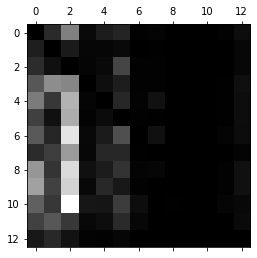

In [93]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)

plt.Figure(figsize=(12,8))

plt.matshow(norm_conf_mx, cmap=plt.cm.gray, )
plt.show()